In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

In [2]:
codewords = [
        '0000000', '0001111', '0110011', '0111100',
        '1010101', '1011010', '1100110', '1101001'
    ]

def encode(bit):
    circ = QuantumCircuit(7)
    
    state = Statevector.from_label('0000000')
    for cw in codewords[1:]:
        state += Statevector.from_label(cw)
    state = state/np.sqrt(8)

    circ.initialize(state)
    if bit:
        circ.x(range(7))
    return circ

Statevector(encode(0)).draw("Latex")

<IPython.core.display.Latex object>

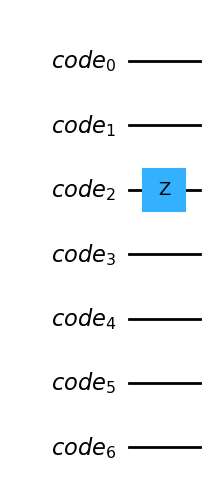

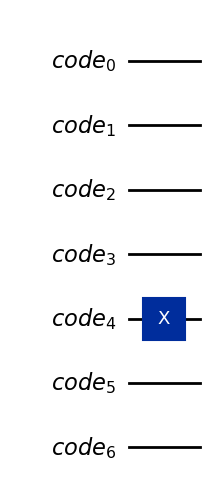

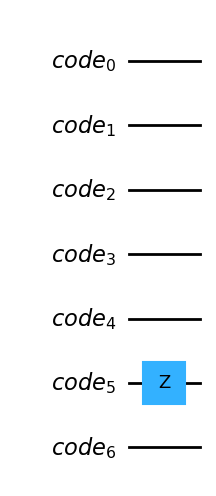

In [3]:
def Pauli(p):
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="Pauli")
    loc = np.random.randint(7)
    dice = np.random.uniform(0,1)
    if dice < p:
        circ.x(loc)
    elif dice < 2*p:
        circ.y(loc)
    elif dice < 3*p:
        circ.z(loc)
    return circ

# test Pauli(p)
for i in range(3):
    display(Pauli(0.3).draw(output="mpl"))

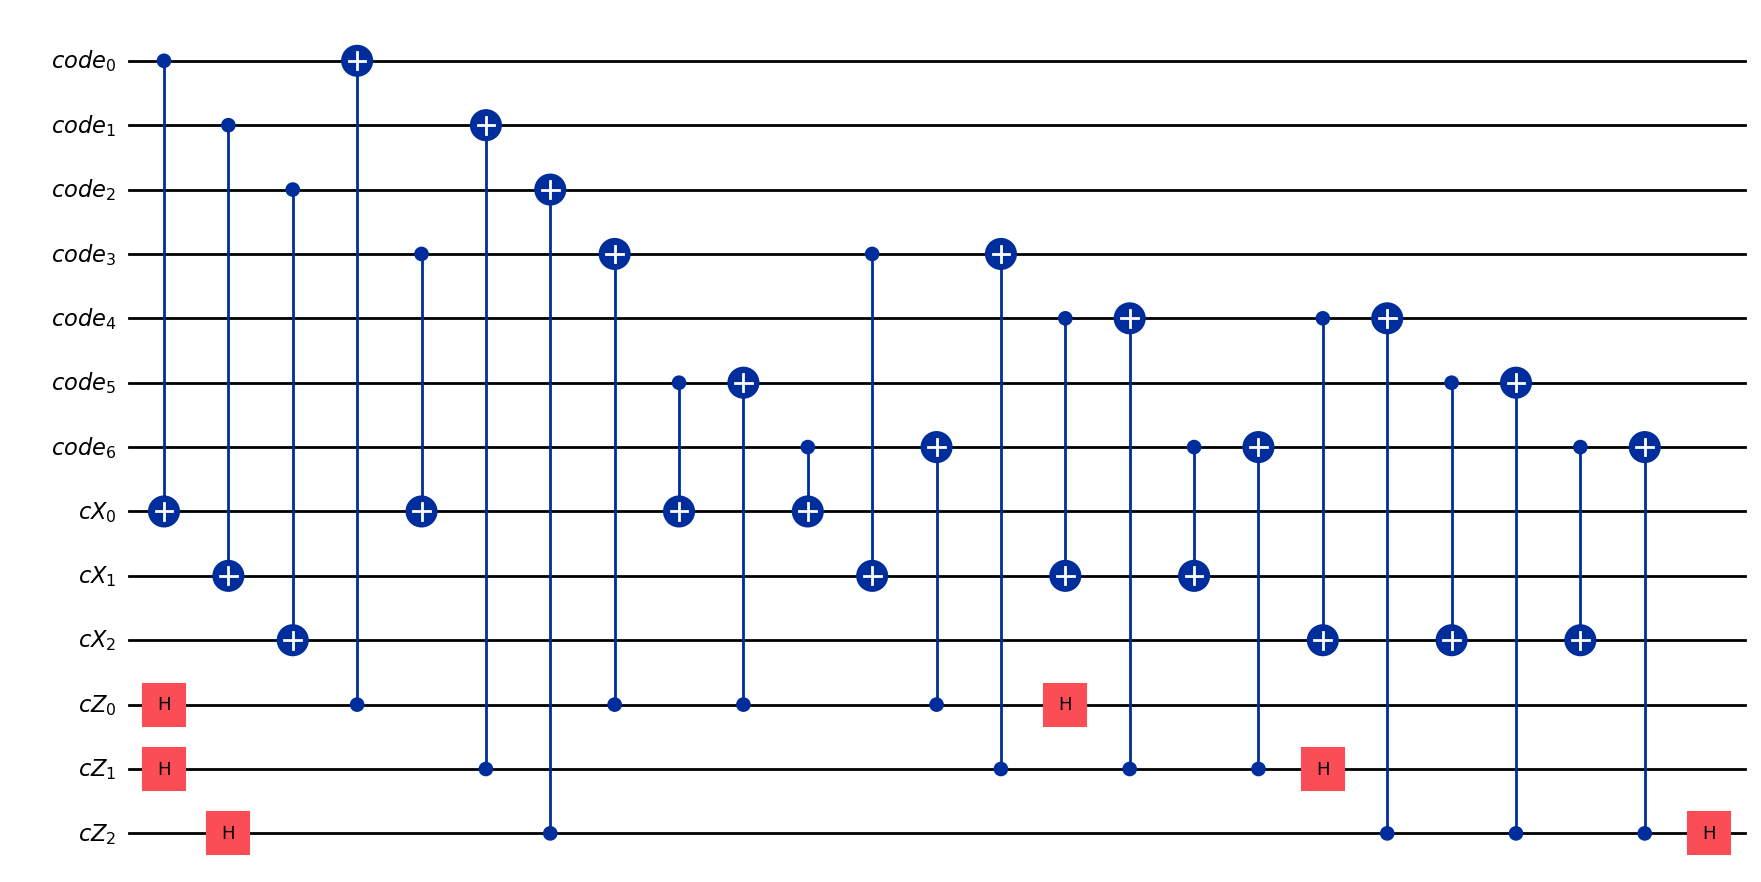

In [4]:
def check():
    code = QuantumRegister(size=7, name="code")
    Xcheck = AncillaRegister(size=3, name="cX")
    Zcheck = AncillaRegister(size=3, name="cZ")
    
    circ = QuantumCircuit(code, name="check")
    circ.add_register(Xcheck, Zcheck)
    
    H = np.array([[1, 0, 0, 1, 0, 1, 1],
                [0, 1, 0, 1, 1, 0, 1],
                [0, 0, 1, 0, 1, 1, 1]])
    
    for idx, row in enumerate(H):
        circ.h(Zcheck[idx])
        for qubit in np.where(row)[0]:
            circ.cx(qubit, Xcheck[idx]) # X check
            circ.cx(Zcheck[idx], qubit) # Z check
        circ.h(Zcheck[idx])
    return circ

check().draw(output="mpl")

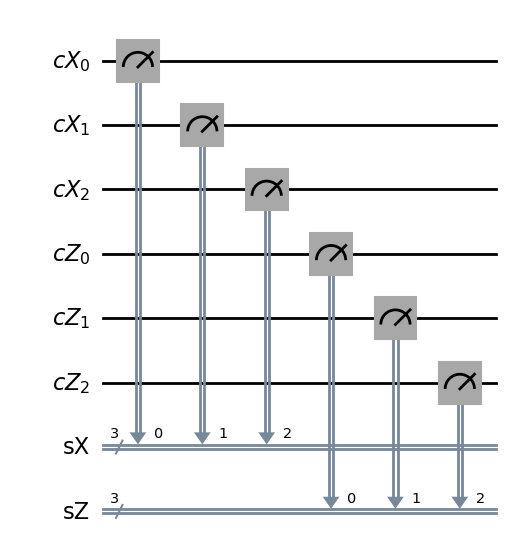

In [5]:
def syndrome():
    Xcheck = AncillaRegister(size=3, name="cX")
    Zcheck = AncillaRegister(size=3, name="cZ")
    Xsyndrome = ClassicalRegister(3, name="sX")
    Zsyndrome = ClassicalRegister(3, name="sZ")
    
    circ = QuantumCircuit(Xcheck, Zcheck, name="syndrome")
    circ.add_register(Xsyndrome, Zsyndrome)
    
    circ.measure(Xcheck, Xsyndrome)
    circ.measure(Zcheck, Zsyndrome)
    return circ

syndrome().draw(output="mpl")

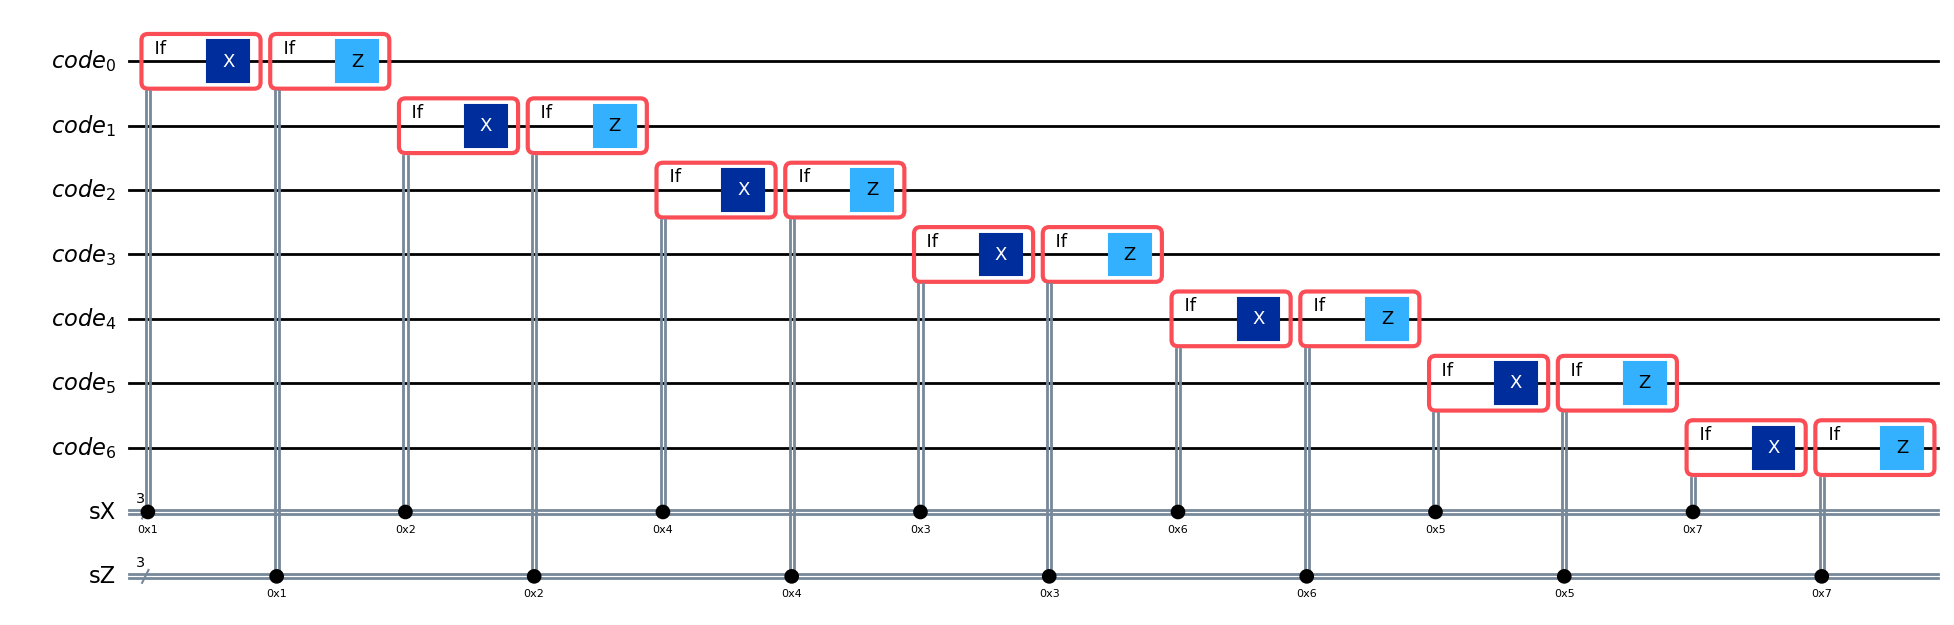

In [6]:
def fix():
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="fix")
    
    Xsyndrome = ClassicalRegister(3, name="sX")
    Zsyndrome = ClassicalRegister(3, name="sZ")
    circ.add_register(Xsyndrome, Zsyndrome)
    
    checklist = [1,2,4,3,6,5,7]
    
    for i in range(7):
        # add the X checks
        with circ.if_test((Xsyndrome, checklist[i])):
            circ.x(i)
        # add the Z checks
        with circ.if_test((Zsyndrome, checklist[i])):
            circ.z(i)
        
    return circ

fix().draw(output="mpl", fold=50)

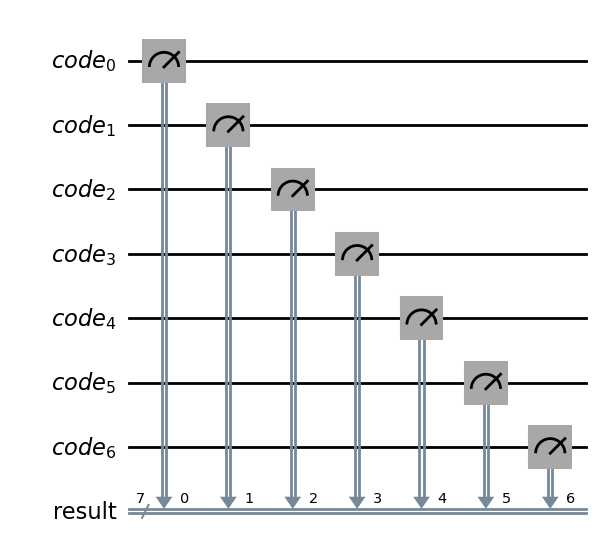

In [7]:
def decode():
    code = QuantumRegister(size=7, name="code")
    circ = QuantumCircuit(code, name="decode")

    result = ClassicalRegister(7, name="result")
    circ.add_register(result)
    circ.measure(range(7), result)
    return circ

decode().draw(output="mpl")

C:\ProgramData\anaconda3\Lib\site-packages\qiskit\circuit\quantumcircuit.py:3808: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


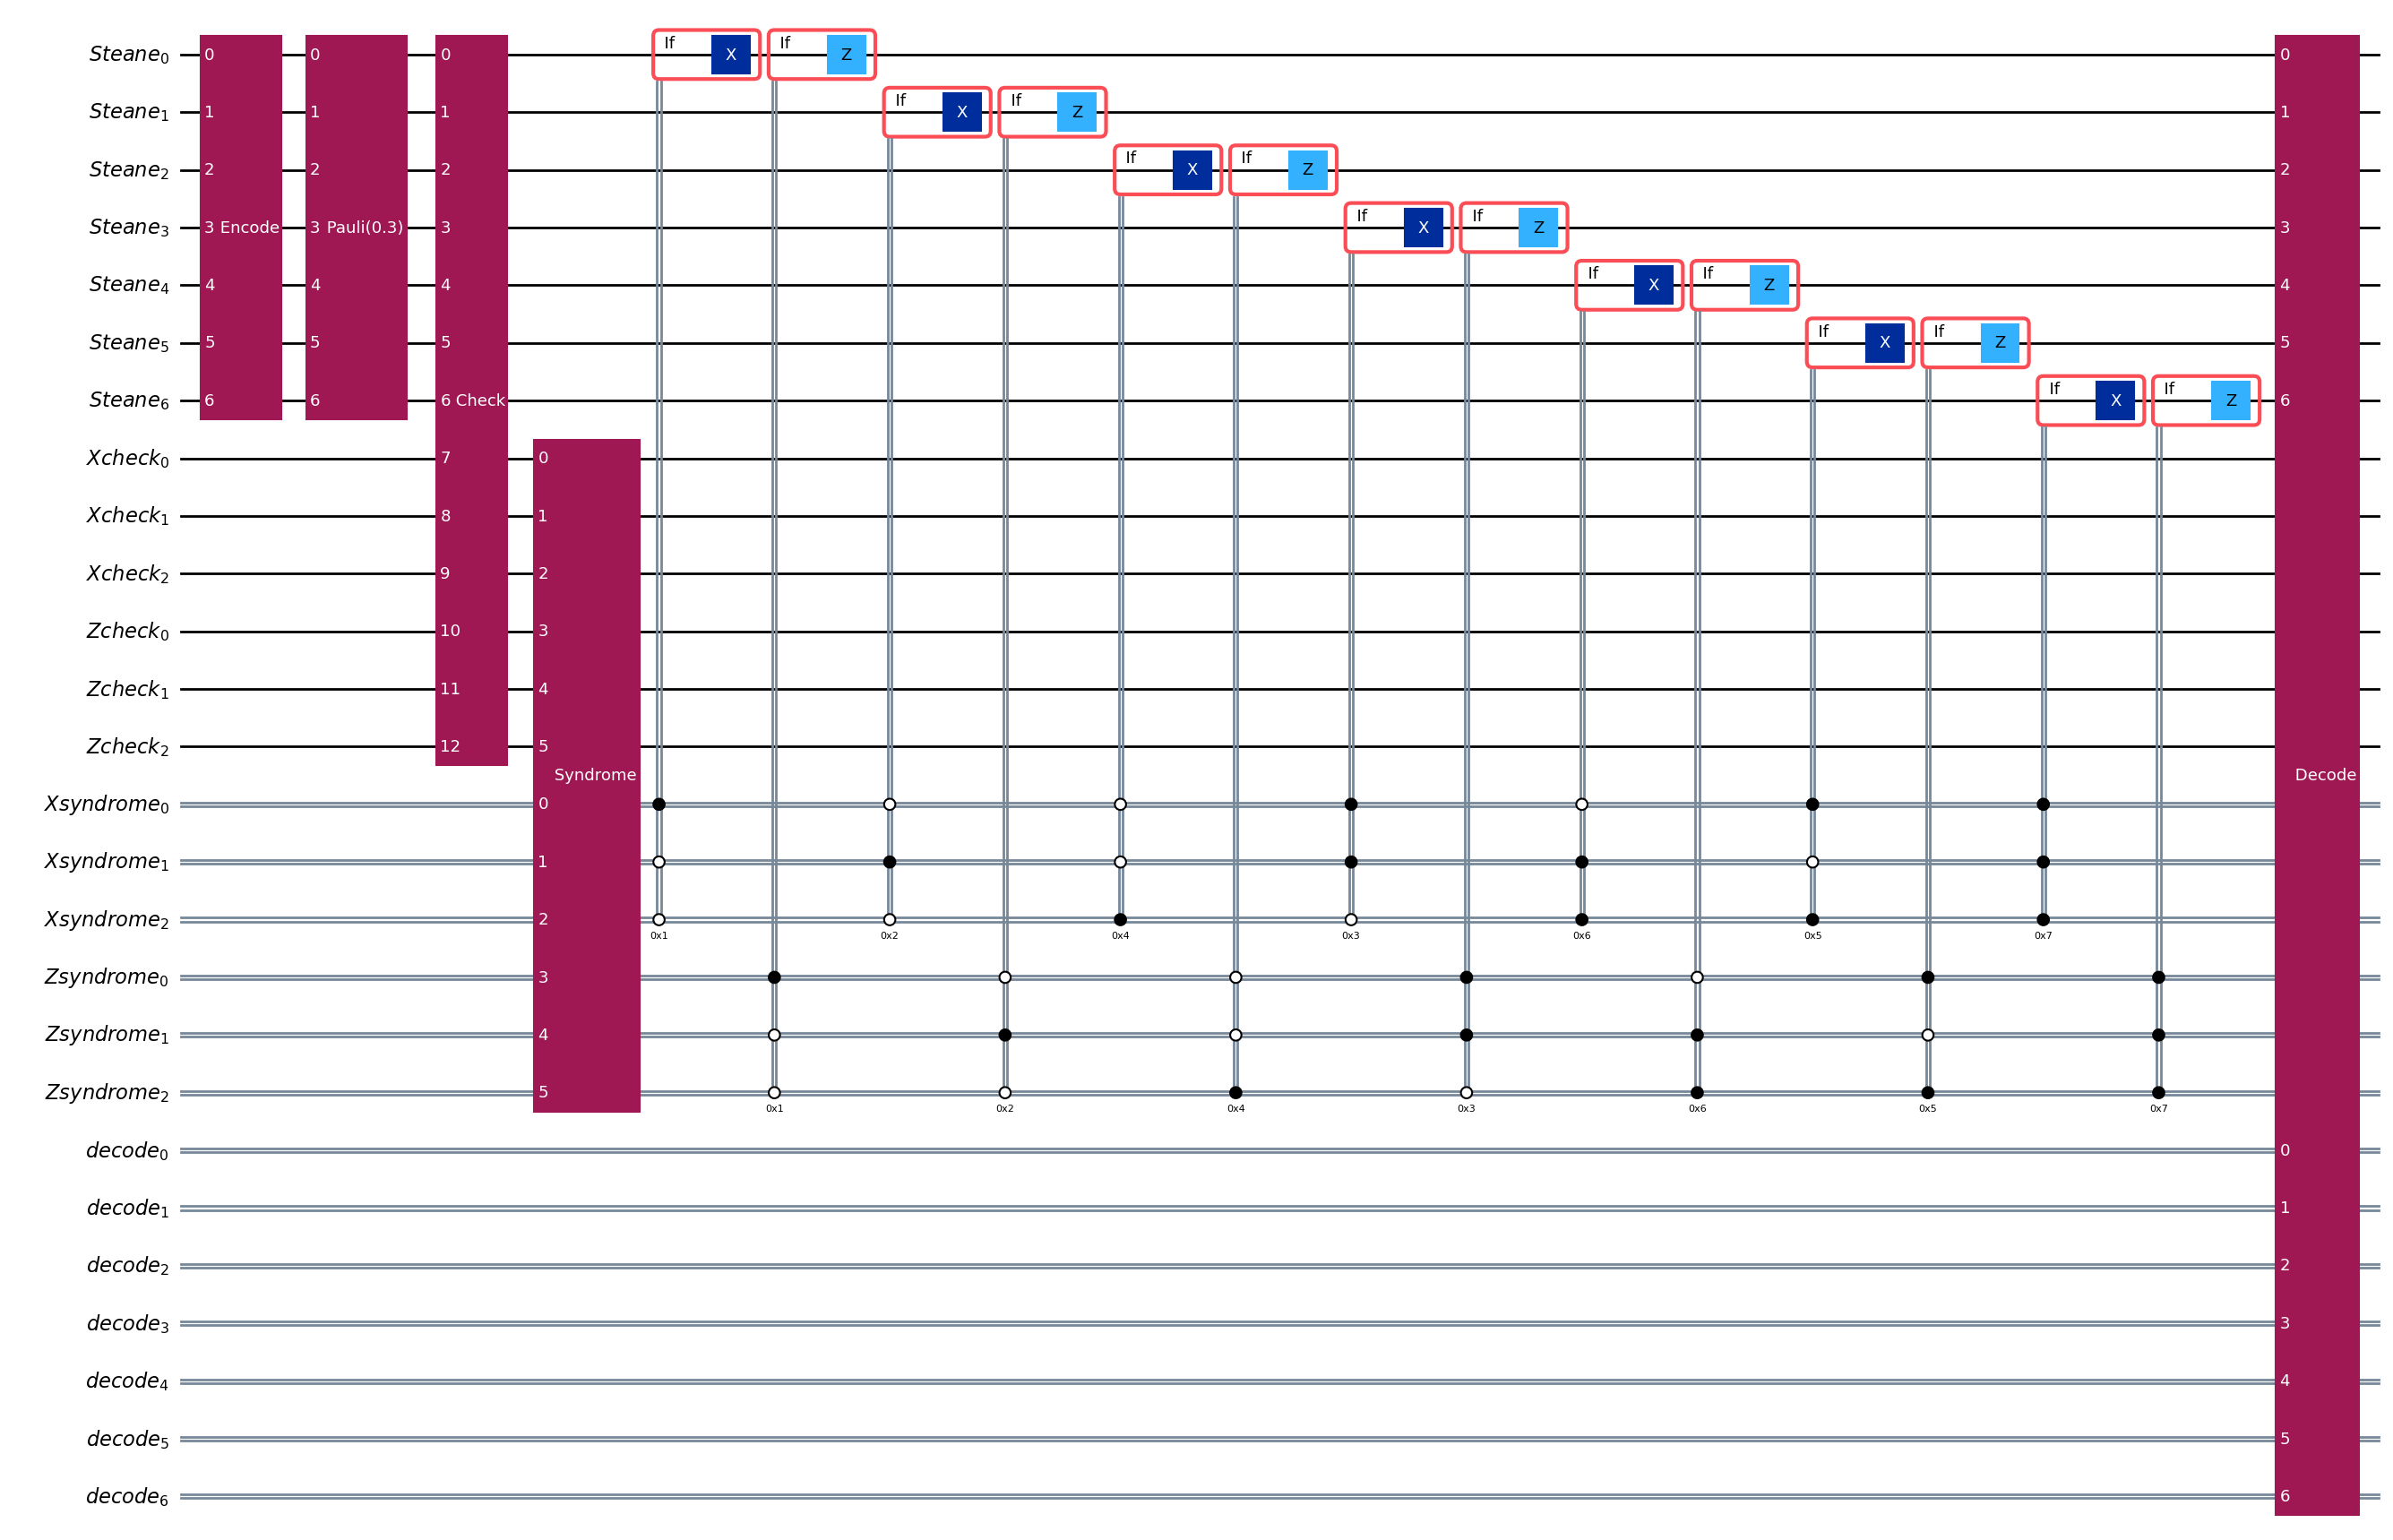

In [8]:
def Steane(p):
    code = QuantumRegister(size=7, name="Steane")
    circ = QuantumCircuit(code, name="Steane")

    encodeInst = encode(0).to_instruction(label=" Encode")
    circ.compose(encodeInst, inplace=True)

    PauliGate = Pauli(p).to_gate(label=" Pauli({})".format(p,"%.2f"))
    circ.compose(PauliGate, inplace=True)

    Xcheck = AncillaRegister(size=3, name="Xcheck")
    Zcheck = AncillaRegister(size=3, name="Zcheck")
    circ.add_register(Xcheck, Zcheck)
    checkGate = check().to_gate(label=" Check")
    circ.compose(checkGate, inplace=True)

    Xsyndrome = ClassicalRegister(3, name="Xsyndrome")
    Zsyndrome = ClassicalRegister(3, name="Zsyndrome")
    circ.add_register(Xsyndrome, Zsyndrome)
    syndromeInst = syndrome().to_instruction(label=" Syndrome")
    circ.compose(syndromeInst, qubits=Xcheck[:]+Zcheck[:], inplace=True)

    circ.compose(fix(), qubits=code, inplace=True)

    result = ClassicalRegister(7, name="decode")
    circ.add_register(result)
    decodeInst = decode().to_instruction(label=" Decode")
    circ.compose(decodeInst, qubits=code, clbits=result, inplace=True)

    return circ

Steane(0.3).draw(output="mpl", fold=50)

In [21]:
simulator = AerSimulator()
rounds = 200
# Transpile the circuit for the backend
compiled_circuit = transpile(Steane(0.3), simulator)
# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)
# Get the measurement counts
counts = job.result().get_counts()

distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

sum([distribution[cw]for cw in codewords if cw in distribution.keys()])

0.51